In [1]:
"""
This notebook analyses the Ego4D meta-data, i.e. ALL data including unannotated.
We plot a stacked barchart for the distribution per user, and an averaged histogram for the scenarios over users.
"""

# Get metadata object
import json
meta_data_file_path = "/fb-agios-acai-efs/Ego4D/ego4d_data/ego4d.json"

with open(meta_data_file_path, 'r') as meta_data_file:
    meta_data_obj = json.load(meta_data_file)

In [2]:
import os.path as osp
import json

# Get annotations
annotation_file_names = [n.strip() for n in """
fho_lta_debug_val.json
fho_lta_taxonomy.json
fho_lta_test_unannotated.json
fho_lta_train.json
fho_lta_train_10000.json
fho_lta_train_5000.json
fho_lta_val.json
""".split('\n') if len(n)> 0]
print(annotation_file_names)

annotation_file_dir = "/fb-agios-acai-efs/Ego4D/ego4d_data/v1/annotations"
annotation_file_name = {'train':"fho_lta_train.json",'val':'fho_lta_val.json','test':'fho_lta_test_unannotated.json'}['train']
assert annotation_file_name in annotation_file_names
annotation_file_path = osp.join(annotation_file_dir, annotation_file_name)

with open(annotation_file_path, 'r') as annotation_file:
    annotation_obj = json.load(annotation_file)


['fho_lta_debug_val.json', 'fho_lta_taxonomy.json', 'fho_lta_test_unannotated.json', 'fho_lta_train.json', 'fho_lta_train_10000.json', 'fho_lta_train_5000.json', 'fho_lta_val.json']


In [3]:
# Check out the annotations
print(annotation_obj.keys())
annotation_obj

"""
The clips indicate a unique action in a timeframe of a specific video.
There are multiple clips 'clip_uid' (and hence actions) per 'video_uid'.
e.g. search on video_uid '9c59e912-2340-4400-b2df-7db3d4066723', resulting in 74 unique clip_uids

Action-Label: is indicated by 'action_idx'.
"""

dict_keys(['version', 'date', 'description', 'split', 'clips'])


"\nThe clips indicate a unique action in a timeframe of a specific video.\nThere are multiple clips 'clip_uid' (and hence actions) per 'video_uid'.\ne.g. search on video_uid '9c59e912-2340-4400-b2df-7db3d4066723', resulting in 74 unique clip_uids\n\nAction-Label: is indicated by 'action_idx'.\n"

In [4]:
# If we want a video-agnostic histogram per user, we will need to merge the annotations with the video meta-data.
# Per-user, we need all the video_uids, and for all these videos we need to collect all 'clip_uids'.
# Per clip there is an associated action, which we want to count for the histogram.


# See pandas merging API: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
import pandas as pd
import numpy as np
from collections import Counter
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

pd.json_normalize(meta_data_obj) # L1 overview
video_df = pd.json_normalize(meta_data_obj['videos'])

video_df.head(n=50)

# Null/unassigned users are omitted automatically
scenarios_per_user_df = video_df.groupby(video_df['fb_participant_id'], as_index=False).agg({'scenarios':list,'video_uid':'count','duration_sec':'sum'})
scenarios_per_user_df['scenarios'] = scenarios_per_user_df['scenarios'].apply(np.concatenate).apply(Counter) # FLATTEN
scenarios_per_user_df = scenarios_per_user_df.rename(columns={"video_uid":"video_count"})
scenarios_per_user_df

,fb_participant_id,scenarios,video_count,duration_sec
0,8.0,{'Crafting/knitting/sewing/drawing/painting': 8},8,22002.95
1,9.0,"{'Playing cards': 1, 'Gardening': 2}",3,3875.60
2,10.0,"{'Household management - caring for kids': 4, ...",10,8202.33
3,11.0,"{'Household management - caring for kids': 37,...",38,27094.81
4,12.0,{'Crafting/knitting/sewing/drawing/painting': 23},23,39797.95
...,...,...,...,...
808,872.0,{'Climbing': 2},2,11913.56
809,873.0,{'Climbing': 2},2,4961.87
810,874.0,{'Climbing': 1},1,2930.60
811,875.0,"{'On a screen (phone/laptop)': 1, 'Tourism': 1...",1,3093.23


In [5]:
# Visualise the histograms
"""“Karl: One way i could imagine visualizing this - for each participant, 
we create a histogram of the scenarios represented in the videos, sort it by 
frequency (so the most frequent scenario is on the left, least on the right), 
and normalize by total number of videos (so the vertical axis is a percentage rather than count). 
Then we plot the mean and standard deviation of all the user-histograms”
"""

# Transfer Counter dict to sorted list
scenario_freqs_per_user_df = scenarios_per_user_df.copy(deep=True)
scenario_freqs_per_user_df['scenarios'] = scenario_freqs_per_user_df['scenarios'].apply(lambda x:sorted(x.values(),reverse=True))

# Normalize with total nb of scenarios
scenario_freqs_per_user_df['scenarios'] = scenario_freqs_per_user_df['scenarios'].apply(lambda x:[ el/sum(x) for el in x])

# Max nb of different scenarios for 1 user (for zero padding the rest for means/stds)
max_scenarios_list_len = scenario_freqs_per_user_df['scenarios'].apply(len).max()
print(max_scenarios_list_len)

# Append zero counts for others
scenario_freqs_per_user_df['scenarios'] = scenario_freqs_per_user_df['scenarios'].apply(
    lambda x:np.pad(x,(0,max_scenarios_list_len - len(x)))
)

# Get mean and std
histogram_means = scenario_freqs_per_user_df['scenarios'].mean()
histogram_stds = pd.DataFrame(scenario_freqs_per_user_df['scenarios'].tolist(), index=scenario_freqs_per_user_df.index).std().tolist()
print(histogram_means)
print(histogram_stds)

scenario_freqs_per_user_df

28
[6.67851345e-01 1.52619452e-01 7.73473502e-02 3.83549919e-02
 2.36844101e-02 1.46683013e-02 8.65244202e-03 4.69351994e-03
 3.50069785e-03 2.37852472e-03 1.60551053e-03 1.13729964e-03
 8.90733072e-04 7.71759618e-04 6.33366127e-04 4.08644042e-04
 2.42415511e-04 1.37533220e-04 1.09074112e-04 6.83783805e-05
 6.83783805e-05 4.31867722e-05 3.75185127e-05 2.61295100e-05
 2.61295100e-05 1.43024686e-05 1.43024686e-05 1.43024686e-05]
[0.32340436381724064, 0.16214184613015745, 0.09963585546256705, 0.06470685212038127, 0.04880289036275291, 0.035602692639208754, 0.025313103030500446, 0.015003028778378776, 0.01250430265598764, 0.00981228761054446, 0.007333142502613389, 0.005513663778405287, 0.004651915396146706, 0.004225177068225029, 0.003781966767878739, 0.0029612854381731936, 0.0020467087881538212, 0.0012780198875280396, 0.0011415134739533887, 0.0008427678269385848, 0.0008427678269385848, 0.0006405025948193233, 0.0006201196786300435, 0.0005288578235128501, 0.0005288578235128501, 0.0004078085022

,fb_participant_id,scenarios,video_count,duration_sec
0,8.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,22002.95
1,9.0,"[0.6666666666666666, 0.3333333333333333, 0.0, ...",3,3875.60
2,10.0,"[0.5, 0.4, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,8202.33
3,11.0,"[0.9736842105263158, 0.02631578947368421, 0.0,...",38,27094.81
4,12.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23,39797.95
...,...,...,...,...
808,872.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,11913.56
809,873.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,4961.87
810,874.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2930.60
811,875.0,"[0.3333333333333333, 0.3333333333333333, 0.333...",1,3093.23


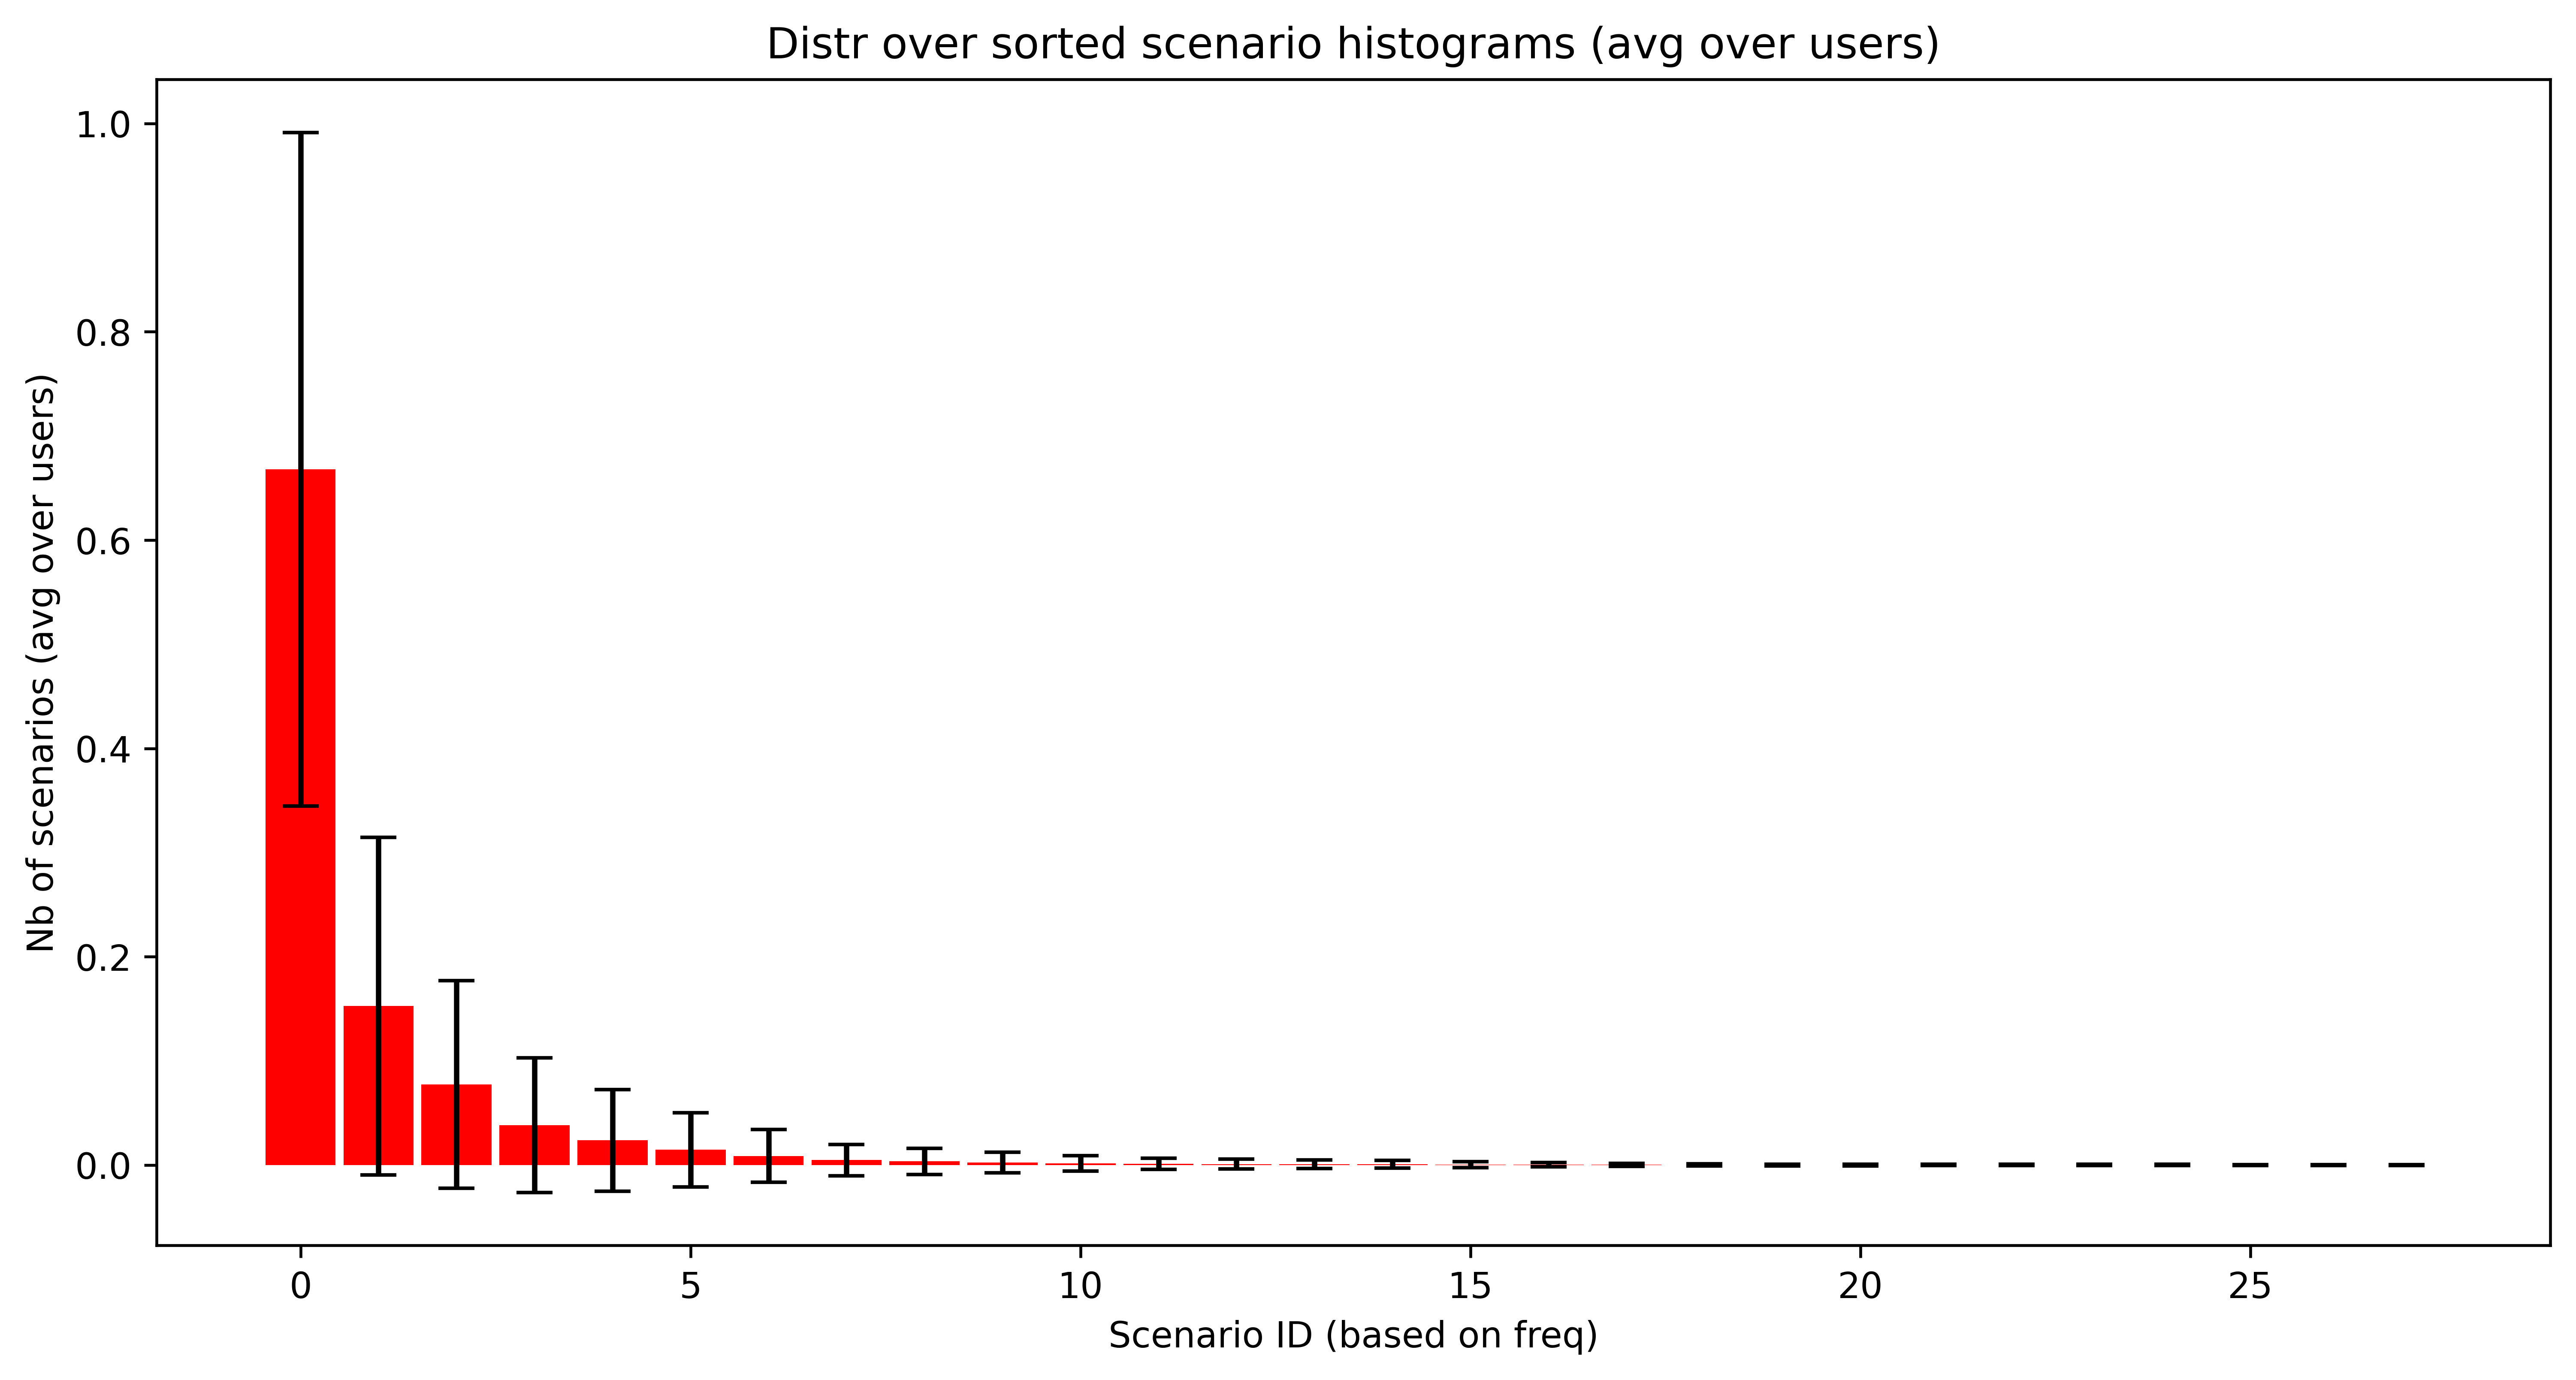

VALS = ['66.785', '15.262', '7.735', '3.835', '2.368', '1.467', '0.865', '0.469', '0.350', '0.238', '0.161', '0.114', '0.089', '0.077', '0.063', '0.041', '0.024', '0.014', '0.011', '0.007', '0.007', '0.004', '0.004', '0.003', '0.003', '0.001', '0.001', '0.001']


<Figure size 432x288 with 0 Axes>

In [6]:
# Visualize by plotting the histogram
import matplotlib.pyplot as plt
import numpy as np

# Barchart API: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
def plot_barchart(x_axis, y_axis, title,ylabel,xlabel='User-ID', grid=False,yerror=None):
    max_val = max(y_axis)
    my_cmap = plt.get_cmap("plasma")
    plt.figure(figsize=(12, 6), dpi=600) # So all bars are visible!
    plt.bar(x_axis, height=y_axis,color='red', align='center', capsize=5,yerr=yerror,width=0.9)
    plt.ylim(None,None)
    plt.xlim(None,None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
    print(f"VALS = {['{:.3f}'.format(x*100) for x in y_axis]}")
    

x_axis_scenario_ids = list(range(len(histogram_means)))
plot_barchart(x_axis_scenario_ids, histogram_means, 
              yerror=histogram_stds,
              title="Distr over sorted scenario histograms (avg over users)",
             ylabel="Nb of scenarios (avg over users)",xlabel="Scenario ID (based on freq)")

df_sorted=     fb_participant_id                                          scenarios  \
89                97.0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
58                66.0  [0.7428571428571429, 0.2571428571428571, 0.0, ...   
278              287.0  [0.32727272727272727, 0.2636363636363636, 0.23...   
59                67.0  [0.6304347826086957, 0.30434782608695654, 0.06...   
128              137.0  [0.15668202764976957, 0.11981566820276497, 0.1...   
..                 ...                                                ...   
68                76.0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
24                32.0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
93               101.0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
672              695.0  [0.6666666666666666, 0.3333333333333333, 0.0, ...   
109              117.0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

     video_count  duration_sec  
89            44     262093.17  

KeyboardInterrupt: 

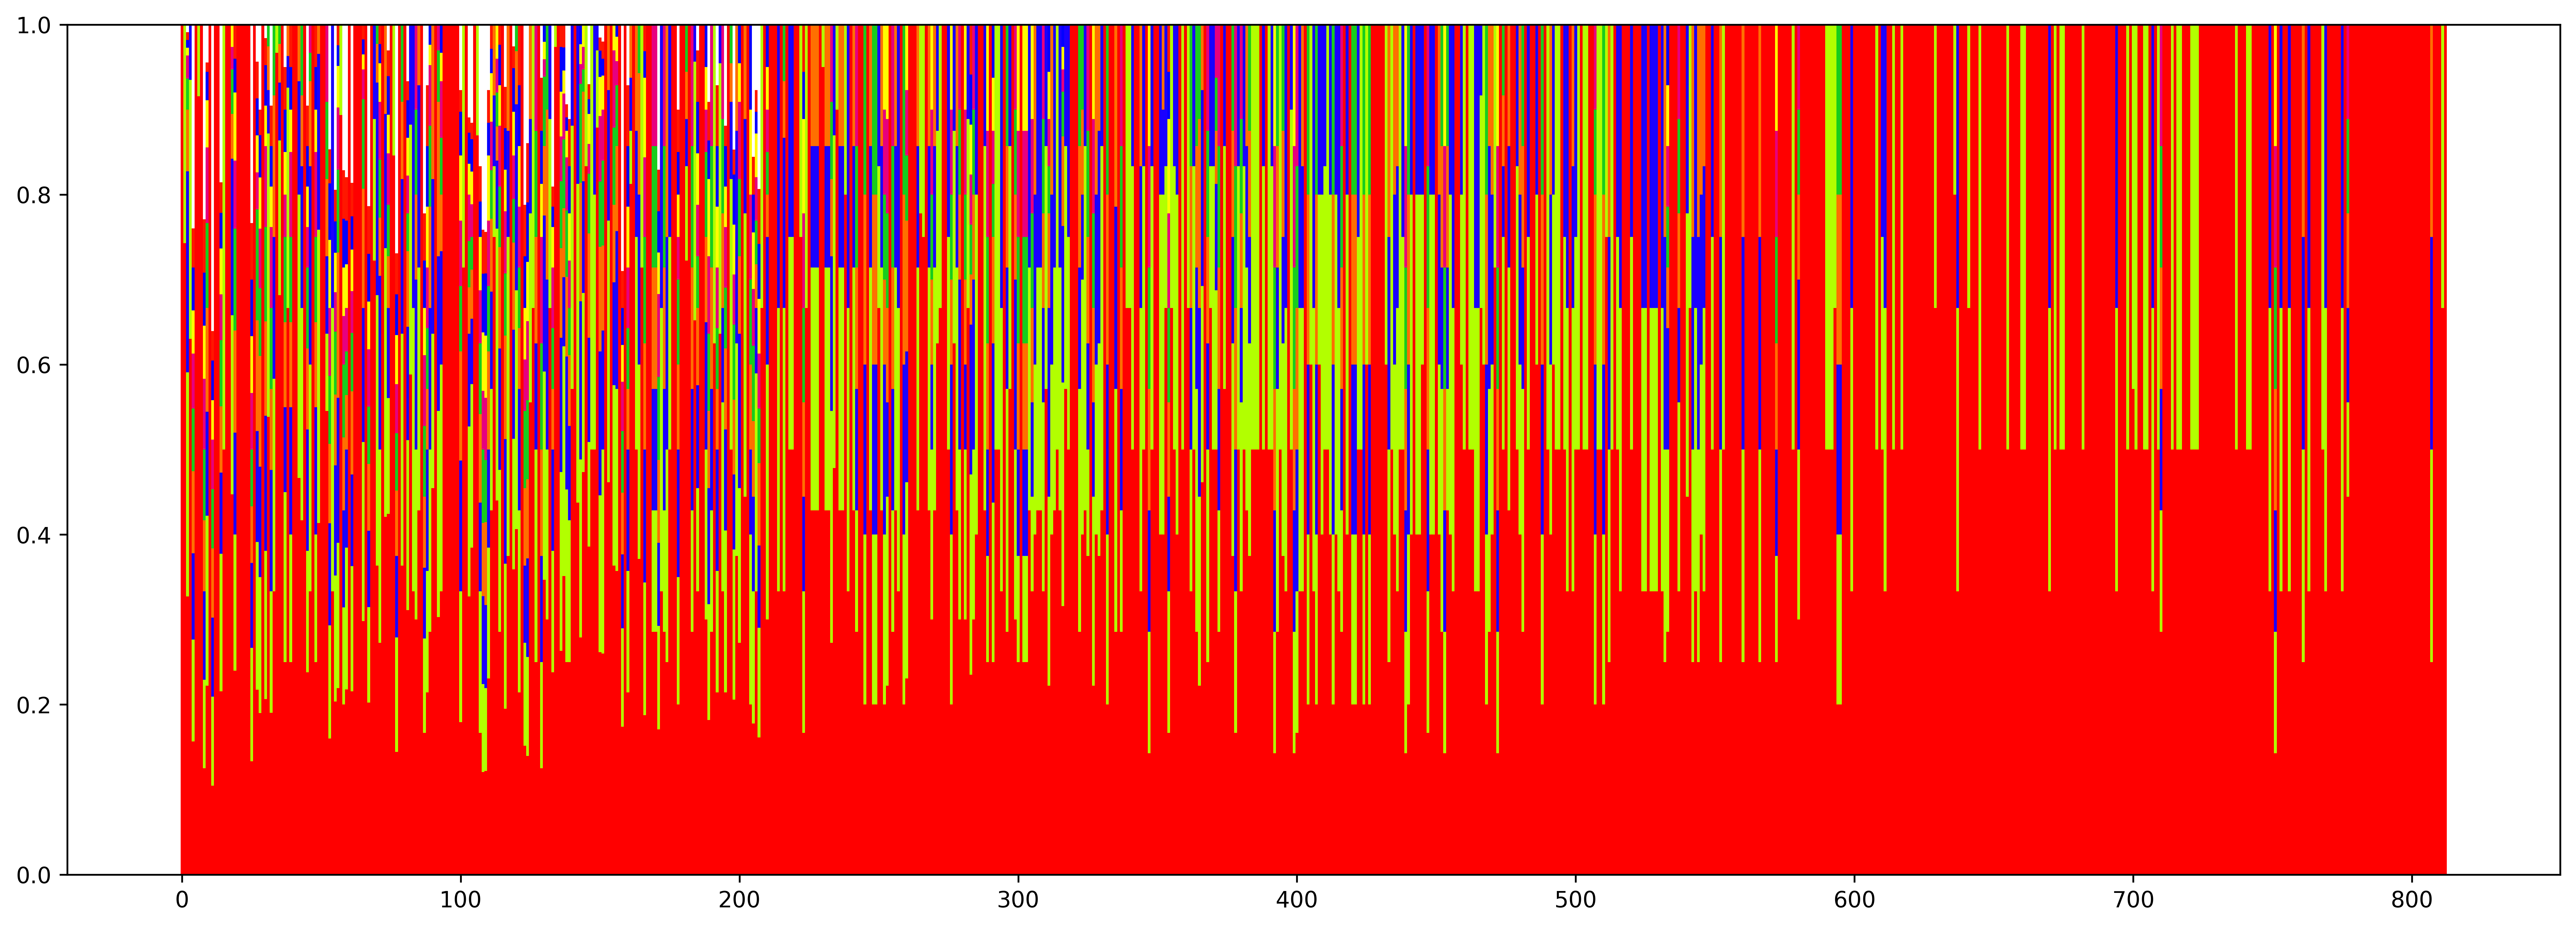

In [8]:
# Stacked Bar Chart: 
# X-AXIS: users on x-axis, where all scenarios from all their videos are accumulated in a single scenario-distribution. 
# This is color-coded per user (same color is not necessarily same scenario for different users).
# Y-AXIS: Distribution for a single user over scenarios (one bar in the stack is a fraction of the scenario-distribution for that user).

def check_sum_one(list_of_distr):
    eps = 1e-5
    for distr in list_of_distr:
        prob_sum = sum(distr)
        assert 1-eps < prob_sum < 1 + eps, f"prob_sum={prob_sum} NOT SUMMING TO ONE"
        
df_sorted = scenario_freqs_per_user_df.sort_values(by=['duration_sec'],ascending=False)
print(f"df_sorted={df_sorted}")

# video_counts_s = df_sorted['video_count'].tolist()
video_lens_s = df_sorted['duration_sec'].tolist()

# Stack bar plots: 
# stack_user_counts = scenario_freqs_per_user_df['scenarios'].tolist()
stack_user_counts_s = df_sorted['scenarios'].tolist()
# print(f"stack_user_counts={stack_user_counts}")
check_sum_one(stack_user_counts_s)

# Transpose: List of 1st entries over users, list of 2nd entries, etc
stack_user_counts_st = np.asarray(stack_user_counts_s)
check_sum_one(stack_user_counts_st)
stack_user_counts_st = stack_user_counts_st.transpose()

plt.figure(figsize=(20, 7), dpi=600) # So all bars are visible!

x_axis = list(range(len(stack_user_counts_st[0])))

# my_cmap = plt.get_cmap("hsv")
my_cmap = plt.get_cmap("prism")
color_steps = np.linspace(0, 1, len(stack_user_counts_st))

# Config
bar_width = 1

# First bar
prev_bar_values = stack_user_counts_st[0].tolist()
plt.bar(x_axis, height=prev_bar_values, align='center', width=bar_width,color=my_cmap(color_steps[0]))
for idx, stack_user_count in enumerate(stack_user_counts_st[1:]):
    color = my_cmap(color_steps[idx+1])
    plt.bar(x_axis, height=stack_user_count.tolist(), color=color,bottom=prev_bar_values, align='center', width=bar_width)
    
    assert len(prev_bar_values) == len(stack_user_count.tolist())
    prev_bar_values = [x+y for x,y in zip(prev_bar_values,stack_user_count.tolist())]


plt.ylim(None,None)
plt.xlim(None,None)
plt.xlabel("User idx - SORTED on total user video len (min) ")
plt.ylabel("Stacked scenario freq")
plt.title("Stacked scenario freq per user - SORTED on total user video len (min)")

# plt.grid(grid)
plt.show()
plt.clf()

